<a href="https://colab.research.google.com/github/AmaanRai1/DS-340-Group-8/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # data visualization

# Import PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler # preprocessing functions
from sklearn.metrics import mean_absolute_error, mean_squared_error # evaluation metrics
from sklearn.linear_model import LinearRegression # linear regression model

from itertools import product # Import itertools for generating combinations
import heapq # Import heapq for getting top elements from a list
from joblib import Parallel, delayed

## **Data**

In [ ]:
# different file adresses for 3 different index data, only one them should be active
# file_address = '/Users/amaanrai/Desktop/DS340w/TechnicalAnalysisStrategyOptimization/ibex.csv'
file_address = '/Users/amaanrai/Desktop/DS340w/TechnicalAnalysisStrategyOptimization/dji.csv'
# file_address = 'data/dji.csv'

# extracting name of the index from file_address
index_name = file_address.split('/')[-1].split('.')[0].upper()

# Read the CSV file into a DataFrame
df = pd.read_csv(file_address)

# Convert the 'date' column to datetime if it's not already in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'date' column as the index
df.set_index('Date', inplace=True)

# Drop 'Volume' and 'Adj Close' columns
df = df.drop(['Volume', 'Adj Close'], axis=1)

/var/folders/td/dz_wwxjj7sq2s6rq_ydp1t3h0000gn/T/ipykernel_20295/3681619214.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [ ]:
df

,Open,High,Low,Close
Date,,,,
2011-01-03,11577.42969,11711.46973,11577.34961,11670.75000
2011-01-04,11670.90039,11698.21973,11635.74023,11691.17969
2011-01-05,11688.61035,11742.67969,11652.88965,11722.88965
2011-01-06,11716.92969,11736.74023,11667.45996,11697.30957
2011-01-07,11696.86035,11726.94043,11599.67969,11674.75977
...,...,...,...,...
2019-12-24,28572.57031,28576.80078,28503.21094,28515.44922
2019-12-26,28539.46094,28624.09961,28535.15039,28621.39063
2019-12-27,28675.33984,28701.66016,28608.98047,28645.25977


In [ ]:
# Define the split date
split_date = pd.to_datetime('2019-01-01')

# Split the data into train and test sets
train_data = df[df.index < split_date]
test_data = df[df.index >= split_date]

In [ ]:
def split_data_x(df, time_window):
    """
    Split a DataFrame into input sequences of a specified time window.
    this function is for x

    Args:
        df (pd.DataFrame): The input DataFrame.
        time_window (int): The length of each input sequence.

    Returns:
        np.ndarray: Numpy array of input sequences.

    """
    data_raw = np.array(df)  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - time_window):
        data.append(data_raw[index: index + time_window].reshape(-1))

    out = np.array(data)

    return out

In [ ]:
def split_data_y(df, time_window):
    """
    Split a DataFrame into input sequences of a specified time window.
    this function is for x

    Args:
        df (pd.DataFrame): The input DataFrame.
        time_window (int): The length of each input sequence.

    Returns:
        np.ndarray: Numpy array of input sequences.

    """
    df = df['Close'] # only need the close price as y
    data_raw = np.array(df)  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - time_window):
        data.append(data_raw[index + time_window])

    out = np.array(data)
    out = np.expand_dims(out, axis=1)

    return out

# **Strategies**

In [ ]:
def calculate_profit_factor(strategy):
    """
    Calculate the profit factor of a trading strategy.

    Args:
        strategy (pd.Series): A pandas Series representing the strategy's trade outcomes.

    Returns:
        float: The profit factor of the strategy.
    """
    positive_trades = strategy.loc[strategy > 0].sum() # Calculate the sum of positive trades
    negative_trades = strategy.loc[strategy < 0].sum() # Calculate the sum of negative trades
    profit_factor = abs(positive_trades / negative_trades) # Calculate the profit factor
    return profit_factor

In [ ]:
def calculate_metrics(df):
    # Calculate number of trades
    num_trades = df['Trades'].sum()

    # Calculate net profit of the trades
    net_profit = df['PriceStrategy'].sum()

    # Calculate profit factor
    profit_factor = calculate_profit_factor(df['Strategy'])

    # Calculate average net of each trade
    avg_net_trade = net_profit / num_trades

    # Calculate maximum drawdown (price)
    max_drawdown = (df['CPriceStrategy'] - df['CPriceStrategy'].cummax()).min()

    # Create a DataFrame to store the metrics
    metrics_df = pd.DataFrame({
        'Number of Trades': [num_trades],
        'Net Profit': [net_profit],
        'Profit Factor': [profit_factor],
        'Average Net per Trade': [avg_net_trade],
        'Maximum Drawdown': [max_drawdown],
    }, index=['Strategy'])

    return metrics_df

## **TEMA**

In [ ]:
def ema(df, period):
    """
    Calculate the Exponential Moving Average (EMA) of a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        period (int): The number of periods to consider for the EMA calculation.

    Returns:
        pd.DataFrame: The DataFrame with EMA values.

    """
    return df.ewm(span = period, min_periods = period).mean()

In [ ]:
def df_change(df, symbol):
    """
    Create a DataFrame with a single column representing the change in closing prices.

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the change in closing prices.

    Returns:
        pd.DataFrame: A DataFrame with a single column representing the change in closing prices.

    """
    temp = pd.DataFrame(df['Close']) # Create a temporary DataFrame with 'Close' column
    temp = temp.rename({'Close': symbol}, axis=1) # Rename the 'Close' column to the specified symbol
    return temp

In [ ]:
def tema_strategy(df, symbol, short_period, mid_period, long_period):
    """
    Implement a trading strategy using TEMA (Triple Exponential Moving Average).

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_period (int): The period for short-term EMA calculation.
        mid_period (int): The period for mid-term EMA calculation.
        long_period (int): The period for long-term EMA calculation.

    Returns:
        pd.DataFrame: A DataFrame containing the trading strategy signals and performance metrics.

    """
    df = df_change(df, symbol) # Calculate the change in closing prices
    temp = df.copy() # Create a copy of the DataFrame

    # Calculate the EMA values for short, mid, and long periods
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)

    # Determine the position based on EMA crossovers
    temp['Position'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))

    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative log returns, cumulative strategy performance, cumulative price, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [ ]:
def optimize_tema_parameters(df, symbol, short_range, mid_range, long_range):
    """
    Optimize TEMA (Triple Exponential Moving Average) parameters by finding top combinations based on CStrategy.

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_range (list): A list of short-term EMA period values to consider.
        mid_range (list): A list of mid-term EMA period values to consider.
        long_range (list): A list of long-term EMA period values to consider.

    Returns:
        list: A list of best parameter combinations.
        list: A list of corresponding CStrategy values.

    """
    top_combinations = []

    # Iterate over all combinations of short, mid, and long periods
    for short_period, mid_period, long_period in product(short_range, mid_range, long_range):
        if short_period < mid_period < long_period:

            # Calculate TEMA strategy performance for the combination of periods
            result = tema_strategy(df, symbol, short_period, mid_period, long_period)
            c_strategy = result['CStrategy'].iloc[-1]

            # Use a heap to maintain the top 5 combinations based on CStrategy
            if len(top_combinations) < 5:
                heapq.heappush(top_combinations, (c_strategy, (short_period, mid_period, long_period)))
            else:
                heapq.heappushpop(top_combinations, (c_strategy, (short_period, mid_period, long_period)))

    # Get the top 5 combinations with highest CStrategy values
    top_combinations = sorted(top_combinations, reverse=True)
    best_combinations = [combo[1] for combo in top_combinations]
    best_c_strategy = [combo[0] for combo in top_combinations]

    return best_combinations, best_c_strategy

In [ ]:
# Define the parameter ranges
short_range = range(2, 25)
mid_range = range(5, 41)
long_range = range(8, 81)

# test parameters
# short_range = range(2, 5)
# mid_range = range(5, 7)
# long_range = range(8, 12)

# Run the optimization
best_combinations, best_c_strategy = optimize_tema_parameters(train_data, index_name, short_range, mid_range, long_range)
best_tema_params = best_combinations[0]

# Print the results
print("Best Combinations:")
for i, combination in enumerate(best_combinations):
    print(f"Combination {i+1}: {combination}")
print("Best CStrategy:", best_c_strategy)

Best Combinations:
Combination 1: (19, 36, 57)
Combination 2: (19, 40, 57)
Combination 3: (19, 36, 58)
Combination 4: (18, 38, 59)
Combination 5: (19, 40, 58)
Best CStrategy: [1.111386245957554, 1.107469523046232, 1.1048858586586678, 1.1034482109687183, 1.1009920442689856]


In [ ]:
print(f"Printing five of the best parameters combinations:\n")

for i, combination in enumerate(best_combinations):
    short_period, mid_period, long_period = combination

    # Run the strategy with the current combination
    strategy_result = tema_strategy(test_data, index_name, short_period, mid_period, long_period,)

    # Calculate the profit factor
    pf_factor = calculate_profit_factor(strategy_result['Strategy'])

    # Print the result
    print(f"Combination {i+1}: {combination}")
    print("Profit Factor:", pf_factor)
    print()

Printing five of the best parameters combinations:

Combination 1: (19, 36, 57)
Profit Factor: 0.8940836261227177

Combination 2: (19, 40, 57)
Profit Factor: 0.9089689897104459

Combination 3: (19, 36, 58)
Profit Factor: 0.8968461788992147

Combination 4: (18, 38, 59)
Profit Factor: 0.8851648664178178

Combination 5: (19, 40, 58)
Profit Factor: 0.9119386639204863



In [ ]:
tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2])

,DJI,ShortEMA,MidEMA,LongEMA,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,
2019-01-02,23346.24023,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-03,22686.22070,NaN,NaN,NaN,0,-0.028678,-0.000000,-660.01953,-0.00000,0.0,0.971729,1.000000,-660.01953,0.00000
2019-01-04,23433.16016,NaN,NaN,NaN,0,0.032394,0.000000,746.93946,0.00000,0.0,1.003723,1.000000,86.91993,0.00000
2019-01-07,23531.34961,NaN,NaN,NaN,0,0.004181,0.000000,98.18945,0.00000,0.0,1.007929,1.000000,185.10938,0.00000
2019-01-08,23787.44922,NaN,NaN,NaN,0,0.010825,0.000000,256.09961,0.00000,0.0,1.018899,1.000000,441.20899,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,28515.44922,28145.721346,27902.490242,27660.264624,1,-0.001264,-0.001264,-36.08008,-36.08008,0.0,1.221415,0.948356,5169.20899,-1305.07814
2019-12-26,28621.39063,28193.288274,27941.349761,27693.412218,1,0.003708,0.003708,105.94141,105.94141,0.0,1.225953,0.951879,5275.15040,-1199.13673
2019-12-27,28645.25977,28238.485424,27979.398986,27726.239632,1,0.000834,0.000834,23.86914,23.86914,0.0,1.226975,0.952673,5299.01954,-1175.26759


In [ ]:
calculate_metrics(tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,9.0,-1282.08791,0.894084,-142.454212,-4258.14845


## **MACD**

In [ ]:
def macd_strategy(df, symbol, short_period, long_period, signal_period):
    """
    Implement a trading strategy using MACD (Moving Average Convergence Divergence).

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_period (int): The period for the short-term EMA calculation.
        long_period (int): The period for the long-term EMA calculation.
        signal_period (int): The period for the signal line calculation.

    Returns:
        pd.DataFrame: A DataFrame containing the trading strategy signals and performance metrics.

    """

    df = df_change(df, symbol) # Calculate the change in closing prices
    temp = df.copy() # Create a copy of the DataFrame

    # Calculate the short-term and long-term EMAs and MACD line
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']

    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']

    # Generate trading signals based on MACD and signal line crossovers
    temp['Position'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp['Position'].shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp['Position'].diff().fillna(0).abs().replace(2,1)

    # Calculate cumulative log returns, cumulative strategy performance, cumulative price, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [ ]:
def optimize_macd_parameters(df, symbol, short_range, long_range, signal_range):
    """
    Optimize MACD (Moving Average Convergence Divergence) parameters by finding top combinations based on CStrategy.

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_range (list): A list of short-term EMA period values to consider.
        long_range (list): A list of long-term EMA period values to consider.
        signal_range (list): A list of signal line period values to consider.

    Returns:
        list: A list of best parameter combinations.
        list: A list of corresponding CStrategy values.

    """
    top_combinations = []

    # Iterate over all combinations of short, long, and signal periods
    for short_period, long_period, signal_period in product(short_range, long_range, signal_range):
        if short_period < long_period:

            # Calculate MACD strategy performance for the combination of periods
            result = macd_strategy(df, symbol, short_period, long_period, signal_period)
            c_strategy = result['CStrategy'].iloc[-1]

            # Use a heap to maintain the top 5 combinations based on CStrategy
            if len(top_combinations) < 5:
                heapq.heappush(top_combinations, (c_strategy, (short_period, long_period, signal_period)))
            else:
                heapq.heappushpop(top_combinations, (c_strategy, (short_period, long_period, signal_period)))

    # Get the top 5 combinations with highest CStrategy values
    top_combinations = sorted(top_combinations, reverse=True)
    best_combinations = [combo[1] for combo in top_combinations]
    best_c_strategy = [combo[0] for combo in top_combinations]

    return best_combinations, best_c_strategy

In [ ]:
# Define the parameter ranges
short_range = range(2, 10)
long_range = range(5, 35)
signal_range = range(5, 20)

# test parameters
# short_range = range(2, 5)
# long_range = range(5, 7)
# signal_range = range(5, 10)

# Run the optimization
best_combinations, best_c_strategy = optimize_macd_parameters(train_data, index_name, short_range, long_range, signal_range)
best_macd_params = best_combinations[0]

# Print the best combinations and CStrategy values
print("Best Combinations:")
for i, combination in enumerate(best_combinations):
    print(f"Combination {i+1}: {combination}")
print("Best CStrategy:", best_c_strategy)

Best Combinations:
Combination 1: (2, 27, 6)
Combination 2: (2, 28, 6)
Combination 3: (2, 21, 8)
Combination 4: (2, 23, 7)
Combination 5: (3, 29, 5)
Best CStrategy: [1.5054777296272908, 1.4794276254625063, 1.4748658139109765, 1.4667662104452412, 1.4587670706728149]


In [ ]:
print(f"Printing five of the best parameters combinations:\n")

for i, combination in enumerate(best_combinations):
    short_period, mid_period, long_period = combination

    # Run the strategy with the current combination
    strategy_result = macd_strategy(test_data, index_name, short_period, mid_period, long_period)

    # Calculate the profit factor
    pf_factor = calculate_profit_factor(strategy_result['Strategy'])

    # Print the result
    print(f"Combination {i+1}: {combination}")
    print("Profit Factor:", pf_factor)
    print()

Printing five of the best parameters combinations:

Combination 1: (2, 27, 6)
Profit Factor: 1.091550810489467

Combination 2: (2, 28, 6)
Profit Factor: 1.0914190674602673

Combination 3: (2, 21, 8)
Profit Factor: 1.021683118535167

Combination 4: (2, 23, 7)
Profit Factor: 1.1155691549238294

Combination 5: (3, 29, 5)
Profit Factor: 1.1016069603370944



In [ ]:
macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2])

,DJI,ShortEMA,LongEMA,MACD Line,Signal Line,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,
2019-01-02,23346.24023,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-03,22686.22070,22851.225582,NaN,NaN,NaN,0,-0.028678,-0.000000,-660.01953,-0.00000,0.0,0.971729,1.000000,-660.01953,0.00000
2019-01-04,23433.16016,23254.103367,NaN,NaN,NaN,0,0.032394,0.000000,746.93946,0.00000,0.0,1.003723,1.000000,86.91993,0.00000
2019-01-07,23531.34961,23441.244581,NaN,NaN,NaN,0,0.004181,0.000000,98.18945,0.00000,0.0,1.007929,1.000000,185.10938,0.00000
2019-01-08,23787.44922,23673.001405,NaN,NaN,NaN,0,0.010825,0.000000,256.09961,0.00000,0.0,1.018899,1.000000,441.20899,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,28515.44922,28512.180779,28025.909789,486.270990,444.750988,1,-0.001264,-0.001264,-36.08008,-36.08008,0.0,1.221415,1.056511,5169.20899,1556.38276
2019-12-26,28621.39063,28584.987346,28068.444135,516.543211,465.263051,1,0.003708,0.003708,105.94141,105.94141,0.0,1.225953,1.060436,5275.15040,1662.32417
2019-12-27,28645.25977,28625.168962,28109.645252,515.523710,479.623240,1,0.000834,0.000834,23.86914,23.86914,0.0,1.226975,1.061320,5299.01954,1686.19331


In [ ]:
# macd strategy metric outputs
calculate_metrics(macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,38.0,1426.77535,1.091551,37.54672,-3397.05862


## **RSI**

In [ ]:
def rsi_strategy(df, symbol, rsi_period):
    """
    Implement a trading strategy using RSI (Relative Strength Index).

    Args:
        df (pd.DataFrame): The input DataFrame containing historical price data.
        symbol (str): The name of the column representing the price data.
        rsi_period (int): The period for the RSI calculation.

    Returns:
        pd.DataFrame: A DataFrame containing the trading strategy signals and performance metrics.
    """

    # Preprocess the data (e.g., calculate price changes)
    df = df_change(df, symbol)
    temp = df.copy()  # Create a copy of the DataFrame

    # Calculate the RSI
    temp['RSI'] = calculate_rsi(temp[symbol], rsi_period)

    # Generate trading signals based on RSI thresholds
    temp['Position'] = np.where(temp['RSI'] < 30, 1,  # Buy when RSI < 30 (Oversold)
                                np.where(temp['RSI'] > 70, -1, 0))  # Sell when RSI > 70 (Overbought)

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price changes
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp['Position'].shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp['Position'].diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative metrics
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp['CStrategy'] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

def calculate_rsi(series, period):
    """Calculates the Relative Strength Index (RSI)."""
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


In [ ]:
def optimize_rsi_parameters(df, symbol, rsi_range):
    """
    Optimize RSI (Relative Strength Index) parameters by finding the best period based on CStrategy.

    Args:
        df (pd.DataFrame): The input DataFrame containing historical price data.
        symbol (str): The name of the column representing the price data.
        rsi_range (list): A list of RSI period values to consider.

    Returns:
        list: A list of best RSI periods.
        list: A list of corresponding CStrategy values.
    """
    top_combinations = []

    # Iterate over all possible RSI periods
    for rsi_period in rsi_range:
        # Calculate the RSI strategy performance for the given period
        result = rsi_strategy(df, symbol, rsi_period)
        c_strategy = result['CStrategy'].iloc[-1]  # Get the final CStrategy value

        # Use a heap to maintain the top 5 combinations based on CStrategy
        if len(top_combinations) < 5:
            heapq.heappush(top_combinations, (c_strategy, rsi_period))
        else:
            heapq.heappushpop(top_combinations, (c_strategy, rsi_period))

    # Get the top 5 RSI periods with highest CStrategy values
    top_combinations = sorted(top_combinations, reverse=True)
    best_periods = [combo[1] for combo in top_combinations]
    best_c_strategy = [combo[0] for combo in top_combinations]

    return best_periods, best_c_strategy

In [ ]:
# Define the parameter range for RSI periods
rsi_range = range(2, 30)  # Adjust this range based on your needs

# Test smaller ranges (for testing purposes)
# rsi_range = range(2, 5)

# Run the optimization
best_periods, best_c_strategy = optimize_rsi_parameters(train_data, index_name, rsi_range)

# Extract the best RSI period
best_rsi_period = best_periods[0]

# Print the best periods and their corresponding CStrategy values
print("Best RSI Periods:")
for i, period in enumerate(best_periods):
    print(f"Period {i+1}: {period} with CStrategy: {best_c_strategy[i]}")

print(f"\nBest RSI Period: {best_rsi_period}")


Best RSI Periods:
Period 1: 5 with CStrategy: 1.4466760535132874
Period 2: 6 with CStrategy: 1.296551920686361
Period 3: 19 with CStrategy: 1.1083528845899164
Period 4: 12 with CStrategy: 1.1053336992069553
Period 5: 4 with CStrategy: 1.0998264237613014

Best RSI Period: 5


In [ ]:
def calculate_profit_factor(strategy_returns):
    """
    Calculate the profit factor for a given strategy.

    Args:
        strategy_returns (pd.Series): A series of strategy returns.

    Returns:
        float: The profit factor (ratio of gross profit to gross loss).
    """
    # Separate profits and losses
    gross_profit = strategy_returns[strategy_returns > 0].sum()
    gross_loss = abs(strategy_returns[strategy_returns < 0].sum())

    # Avoid division by zero by checking for zero gross loss
    if gross_loss == 0:
        return float('inf')  # Return infinity if there are no losses

    return gross_profit / gross_loss

In [ ]:
print(f"Printing five of the best RSI period combinations:\n")

for i, period in enumerate(best_periods):
    # Run the RSI strategy with the current period
    strategy_result = rsi_strategy(test_data, index_name, period)

    # Calculate the profit factor
    pf_factor = calculate_profit_factor(strategy_result['Strategy'])

    # Print the result
    print(f"Period {i+1}: {period}")
    print("Profit Factor:", pf_factor)
    print()


Printing five of the best RSI period combinations:

Period 1: 5
Profit Factor: 0.9327491769359932

Period 2: 6
Profit Factor: 0.9942770705860643

Period 3: 19
Profit Factor: 1.1857232329978318

Period 4: 12
Profit Factor: 0.9343438512928528

Period 5: 4
Profit Factor: 1.0000462623590258



In [ ]:
rsi_strategy(test_data, index_name, best_rsi_period)

,DJI,RSI,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,
2019-01-02,23346.24023,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-03,22686.22070,NaN,0,-0.028678,-0.000000,-660.01953,-0.00000,0.0,0.971729,1.000000,-660.01953,0.00000
2019-01-04,23433.16016,NaN,0,0.032394,0.000000,746.93946,0.00000,0.0,1.003723,1.000000,86.91993,0.00000
2019-01-07,23531.34961,NaN,0,0.004181,0.000000,98.18945,0.00000,0.0,1.007929,1.000000,185.10938,0.00000
2019-01-08,23787.44922,62.525464,0,0.010825,0.000000,256.09961,0.00000,0.0,1.018899,1.000000,441.20899,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,28515.44922,82.998650,-1,-0.001264,0.001264,-36.08008,36.08008,0.0,1.221415,0.973246,5169.20899,-703.21872
2019-12-26,28621.39063,92.057595,-1,0.003708,-0.003708,105.94141,-105.94141,0.0,1.225953,0.969644,5275.15040,-809.16013
2019-12-27,28645.25977,89.402518,-1,0.000834,-0.000834,23.86914,-23.86914,0.0,1.226975,0.968836,5299.01954,-833.02927


In [ ]:
calculate_metrics(rsi_strategy(test_data, index_name, best_rsi_period))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,71.0,-649.91013,0.932749,-9.153664,-2310.53514


# **Prediction**

## **Linear Regression**

In [ ]:
# setting up the lookback parameter
time_window = 6

In [ ]:
# creating x_train, y_train, x_test and y_test data
x_train = split_data_x(train_data, time_window)
y_train = split_data_y(train_data, time_window)
x_test = split_data_x(test_data, time_window)
y_test = split_data_y(test_data, time_window)

In [ ]:
# printing shape of x and y data
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2006, 24)
y_train.shape =  (2006, 1)
x_test.shape =  (246, 24)
y_test.shape =  (246, 1)


In [ ]:
# Create and train the linear regression model
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

LinearRegression()

In [ ]:
# Make predictions on the test set
y_pred = regression_model.predict(x_test)

In [ ]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate the symmetric mean absolute percentage error (sMAPE)
smape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 2000)
print('Symmetric Mean Absolute Percentage Error (sMAPE):', smape)

# Calculate the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 1000
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Absolute Error (MAE): 142.82123091080823
Root Mean Squared Error (RMSE): 192.96276950548136
Symmetric Mean Absolute Percentage Error (sMAPE): 5.4461528335938105
Mean Absolute Percentage Error (MAPE): 5.446197224601569


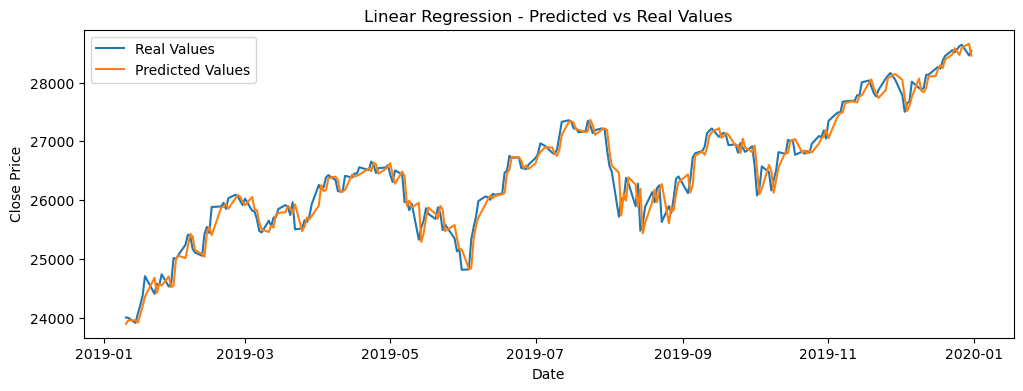

In [ ]:
# Plotting the predicted values and real values
plt.figure(figsize=(12, 4))
plt.plot(test_data.iloc[time_window:].index, y_test, label='Real Values')
plt.plot(test_data.iloc[time_window:].index, y_pred, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Linear Regression - Predicted vs Real Values')
plt.legend()
plt.show()

In [ ]:
# saving the prediction price for further use
y_pred_lr = pd.DataFrame(y_pred)

# Rename the column
y_pred_lr = y_pred_lr.rename(columns={0: 'Predicted'})

# Add 10 rows with NaN values at the top
y_pred_lr = pd.concat([pd.DataFrame(np.nan,
                                    index=np.arange(time_window),
                                    columns=['Predicted']), y_pred_lr],
                      ignore_index=True)

## **ANN**

In [ ]:
# Define the neural network architecture
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x[:, -1] # Output only the last column (close price)

In [ ]:
# Preprocess the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data[['Open', 'Close', 'High', 'Low']])
test_data_scaled = scaler.fit_transform(test_data[['Open', 'Close', 'High', 'Low']])

# Create a new DataFrame with scaled values and original column names
train_data_scaled = pd.DataFrame(train_data_scaled, columns=['Open', 'Close', 'High', 'Low'])
test_data_scaled = pd.DataFrame(test_data_scaled, columns=['Open', 'Close', 'High', 'Low'])

In [ ]:
# creating x_train, y_train, x_test and y_test data
x_train = split_data_x(train_data_scaled, time_window)
y_train = split_data_y(train_data_scaled, time_window)
x_test = split_data_x(test_data_scaled, time_window)
y_test = split_data_y(test_data, time_window)

In [ ]:
# transforming numpy to tensor
x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
# Set the hyperparameters
hidden_size = 16
lr = 0.00001
num_iterations = 5000

In [ ]:
# Define the model
input_size = x_train.shape[1]
output_size = 1
model = ANN(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Train the model
for iteration in range(num_iterations):
    # Forward pass
    output = model(x_train)
    loss = criterion(output, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss
    if (iteration + 1) % 500 == 0:
        print(f'Iteration: {iteration + 1}, Loss: {loss.item()}')

/Users/amaanrai/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2006, 1])) that is different to the input size (torch.Size([2006])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration: 500, Loss: 0.1376028060913086
Iteration: 1000, Loss: 0.11781556159257889
Iteration: 1500, Loss: 0.10275628417730331
Iteration: 2000, Loss: 0.09385201334953308
Iteration: 2500, Loss: 0.08928553014993668
Iteration: 3000, Loss: 0.08714441955089569
Iteration: 3500, Loss: 0.08589331060647964
Iteration: 4000, Loss: 0.08476244658231735
Iteration: 4500, Loss: 0.08354612439870834
Iteration: 5000, Loss: 0.08223775774240494


In [ ]:
# Compute predictions on the test data
y_pred = model(x_test)

# Reshape the y_pred array to match the shape of the original data
y_pred = y_pred.detach().numpy().reshape(-1, 1)

# Scale the test_data['Close'] using the same scaler used for training data
temp = scaler.fit_transform(test_data[['Close']])

# Inverse transform the scaled y_pred values to get the actual predicted values
y_pred = scaler.inverse_transform(y_pred)

# Convert y_test tensor to a NumPy array
y_test = y_test.detach().numpy()

In [ ]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate the symmetric mean absolute percentage error (sMAPE)
smape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 2000)
print('Symmetric Mean Absolute Percentage Error (sMAPE):', smape)

# Calculate the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 1000
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Absolute Error (MAE): 1185.5928
Root Mean Squared Error (RMSE): 1325.1271
Symmetric Mean Absolute Percentage Error (sMAPE): 45.327118
Mean Absolute Percentage Error (MAPE): 44.10185292363167


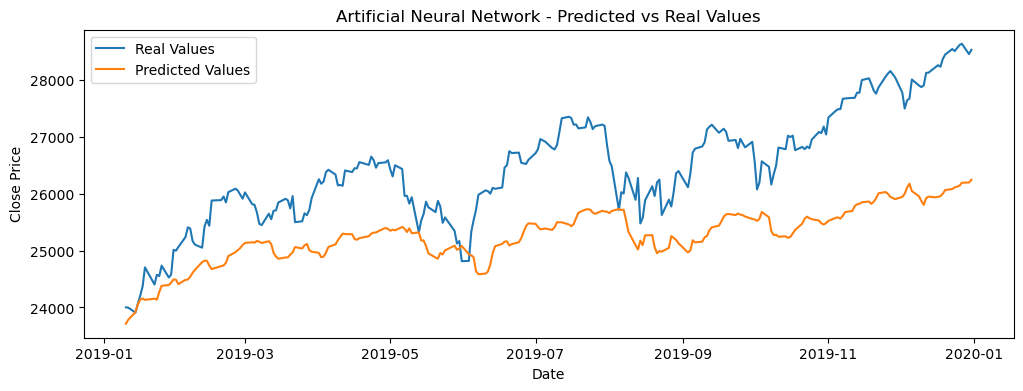

In [ ]:
# Plotting the predicted values and real values
plt.figure(figsize=(12, 4))
plt.plot(test_data.iloc[time_window:].index, y_test, label='Real Values')
plt.plot(test_data.iloc[time_window:].index, y_pred, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Artificial Neural Network - Predicted vs Real Values')
plt.legend()
plt.show()

In [ ]:
# saving the prediction price for further use
y_pred_ann = pd.DataFrame(y_pred)

# Rename the column
y_pred_ann = y_pred_ann.rename(columns={0: 'Predicted'})

# Add 10 rows with NaN values at the top
y_pred_ann = pd.concat([pd.DataFrame(np.nan,
                                    index=np.arange(time_window),
                                    columns=['Predicted']), y_pred_ann],
                      ignore_index=True)

# **LSTM**

In [ ]:
# 1. Data Preparation
def prepare_data_for_lstm(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Assuming you're using the 'Close' prices
data = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

seq_length = 10  # You can adjust this
X, y = prepare_data_for_lstm(data_scaled, seq_length)

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# 2. Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 3. Train the model
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 100
batch_size = 32

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 4. Make predictions
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = scaler.inverse_transform(y_pred.numpy())
    y_test = scaler.inverse_transform(y_test.numpy())

# Adjust the split to consider the sequence length
adjusted_split = len(df) - len(y_pred)
test_data = df.iloc[adjusted_split:]
print(f"Adjusted Test Data Shape: {test_data.shape}")  # Should print (255, <num_cols>)

# Create the y_pred DataFrame with matching index
y_pred_lstm = pd.DataFrame(
    y_pred, columns=['Predicted'], index=test_data.index[:len(y_pred)]
)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')

# 5. Integrate with trading strategy
# You can now use the LSTM predictions (y_pred) in your trading strategy
# For example, you could replace the linear regression predictions with these LSTM predictions
test_data_2019 = test_data[test_data.index.year == 2019]
# Ensure y_pred only contains predictions for 2019
y_pred_2019 = y_pred[-len(test_data_2019):]  # Take only the last n predictions matching 2019
y_pred_lstm = pd.DataFrame(
    y_pred_2019, columns=['Predicted'], index=test_data_2019.index
)
# Verify alignment
print(f"y_pred_2019 Shape: {y_pred_2019.shape}")
print(f"Test Data 2019 Shape: {test_data_2019.shape}")
print(y_pred_lstm.head())



Epoch [10/100], Loss: 0.0006
Epoch [20/100], Loss: 0.0001
Epoch [30/100], Loss: 0.0001
Epoch [40/100], Loss: 0.0001
Epoch [50/100], Loss: 0.0003
Epoch [60/100], Loss: 0.0002
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0001
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0001
Adjusted Test Data Shape: (451, 4)
MAE: 204.1705, RMSE: 279.3989
y_pred_2019 Shape: (252, 1)
Test Data 2019 Shape: (252, 4)
               Predicted
Date                    
2019-01-02  23320.802734
2019-01-03  23443.906250
2019-01-04  23153.312500
2019-01-07  23344.349609
2019-01-08  23525.273438


# **Hybrid Strategies**

## **Strategy 1**

![image.png](attachment:image.png)

### **hTEMA**

In [ ]:
def htema_strategy(df, symbol, short_period, mid_period, long_period, y_pred):
    """
    Implements a trading strategy based on Hull Triple Exponential Moving Average (HTEMA).

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the ShortEMA.
        mid_period (int): Mid period for calculating the MidEMA.
        long_period (int): Long period for calculating the LongEMA.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows

    temp = df.copy() # Make a copy of the dataframe

    # Calculate EMAs for different periods
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)

    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))

    # Determine strategy position based on EMAs
    temp['StrategyPosition'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))

    # Determine overall position based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) | (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) & (temp['PredictionPosition'] == -1), -1, 0))

    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [ ]:
htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm)


,DJI,ShortEMA,MidEMA,LongEMA,PredictionPrice,PredictionPosition,StrategyPosition,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,,,
2019-01-02,23346.24023,NaN,NaN,NaN,23320.802734,-1,0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-03,22686.22070,NaN,NaN,NaN,23443.906250,-1,0,0,-0.028678,-0.000000,-660.01953,-0.00000,0.0,0.971729,1.000000,-660.01953,0.00000
2019-01-04,23433.16016,NaN,NaN,NaN,23153.312500,1,0,1,0.032394,0.000000,746.93946,0.00000,1.0,1.003723,1.000000,86.91993,0.00000
2019-01-07,23531.34961,NaN,NaN,NaN,23344.349609,1,0,1,0.004181,0.004181,98.18945,98.18945,0.0,1.007929,1.004190,185.10938,98.18945
2019-01-08,23787.44922,NaN,NaN,NaN,23525.273438,1,0,1,0.010825,0.010825,256.09961,256.09961,0.0,1.018899,1.015119,441.20899,354.28906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,28515.44922,28145.721346,27902.490242,27660.264624,28592.076172,1,1,1,-0.001264,-0.001264,-36.08008,-36.08008,0.0,1.221415,1.415269,5169.20899,8934.87497
2019-12-26,28621.39063,28193.288274,27941.349761,27693.412218,28616.777344,1,1,1,0.003708,0.003708,105.94141,105.94141,0.0,1.225953,1.420527,5275.15040,9040.81638
2019-12-27,28645.25977,28238.485424,27979.398986,27726.239632,28676.865234,-1,1,1,0.000834,0.000834,23.86914,23.86914,0.0,1.226975,1.421712,5299.01954,9064.68552


#### **Comparing TEMA and hTEMA**

In [ ]:
calculate_metrics(tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,17.0,-1000.32035,0.962861,-58.842374,-5122.12111


In [ ]:
calculate_metrics(htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,40.0,10502.89257,2.067523,262.572314,-1641.41993


### **hMACD**

In [ ]:
def hmacd_strategy(df, symbol, short_period, long_period, signal_period, y_pred):
    """
    Implements a trading strategy based on the Moving Average Convergence Divergence (MACD) indicator.

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the short exponential moving average (ShortEMA).
        long_period (int): Long period for calculating the long exponential moving average (LongEMA).
        signal_period (int): Signal period for calculating the signal line.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows
    temp = df.copy() # Make a copy of the dataframe

    # Calculate MACD line using short and long EMAs
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']

    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']

    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))

    # Determine strategy position based on MACD line and signal line
    temp['StrategyPosition'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))

    # Generate trading signals based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) | (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) & (temp['PredictionPosition'] == -1), -1, 0))

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [ ]:
hmacd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lstm)

,DJI,ShortEMA,LongEMA,MACD Line,Signal Line,PredictionPrice,PredictionPosition,StrategyPosition,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,,,,
2019-01-02,23346.24023,NaN,NaN,NaN,NaN,23320.802734,-1,0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-03,22686.22070,22851.225582,NaN,NaN,NaN,23443.906250,-1,0,0,-0.028678,-0.000000,-660.01953,-0.00000,0.0,0.971729,1.000000,-660.01953,0.00000
2019-01-04,23433.16016,23254.103367,NaN,NaN,NaN,23153.312500,1,0,1,0.032394,0.000000,746.93946,0.00000,1.0,1.003723,1.000000,86.91993,0.00000
2019-01-07,23531.34961,23441.244581,NaN,NaN,NaN,23344.349609,1,0,1,0.004181,0.004181,98.18945,98.18945,0.0,1.007929,1.004190,185.10938,98.18945
2019-01-08,23787.44922,23673.001405,NaN,NaN,NaN,23525.273438,1,0,1,0.010825,0.010825,256.09961,256.09961,0.0,1.018899,1.015119,441.20899,354.28906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,28515.44922,28512.180779,28025.909789,486.270990,444.750988,28592.076172,1,1,1,-0.001264,-0.001264,-36.08008,-36.08008,0.0,1.221415,1.580010,5169.20899,11992.41400
2019-12-26,28621.39063,28584.987346,28068.444135,516.543211,465.263051,28616.777344,1,1,1,0.003708,0.003708,105.94141,105.94141,0.0,1.225953,1.585880,5275.15040,12098.35541
2019-12-27,28645.25977,28625.168962,28109.645252,515.523710,479.623240,28676.865234,-1,1,1,0.000834,0.000834,23.86914,23.86914,0.0,1.226975,1.587203,5299.01954,12122.22455


#### **Comparing MACD and hMACD**

In [ ]:
calculate_metrics(macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,75.0,7314.3066,1.249766,97.524088,-3397.05862


In [ ]:
calculate_metrics(hmacd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,49.0,11862.80659,2.087199,242.098094,-2599.33987


## **hRSI**

In [ ]:
def hrsi_strategy(df, symbol, rsi_period, y_pred):
    """
    Implements a trading strategy based on the Relative Strength Index (RSI) combined with machine learning predictions.

    Args:
        df (pd.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe representing the price data.
        rsi_period (int): Look-back period for RSI calculation.
        y_pred (pd.DataFrame): Dataframe containing predicted values.

    Returns:
        pd.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    # Align the dataframe with the predictions
    df = df_change(df, symbol)  # Preprocess data (e.g., handle NaNs or changes)
    adjusted_split = len(df) - len(y_pred)  # Find the index to align with predictions
    df = df.iloc[adjusted_split:]  # Trim the DataFrame
    temp = df.copy()  # Make a copy of the aligned dataframe

    # Calculate the RSI
    temp['RSI'] = calculate_rsi(temp[symbol], rsi_period)

    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where(
        temp['PredictionPrice'] < temp[symbol].shift(-1), 1,  # Predict price increase -> Buy
        np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0)  # Predict price drop -> Sell
    )

    # Determine strategy position based on RSI
    temp['StrategyPosition'] = np.where(
        temp['RSI'] < 30, 1,  # Buy when RSI < 30 (Oversold)
        np.where(temp['RSI'] > 70, -1, 0)  # Sell when RSI > 70 (Overbought)
    )

    # Generate final trading signals by combining strategy and prediction positions
    temp['Position'] = np.where(
        (temp['StrategyPosition'] == 1) | (temp['PredictionPosition'] == 1), 1,
        np.where((temp['StrategyPosition'] == -1) & (temp['PredictionPosition'] == -1), -1, 0)
    )

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price changes
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp['Position'].shift(1) * temp['PriceChange']

    # Calculate the number of trades and ensure single trades
    temp['Trades'] = temp['Position'].diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative metrics
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp['CStrategy'] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [ ]:
hrsi_strategy(test_data, index_name, best_rsi_period, y_pred_lstm)

,DJI,RSI,PredictionPrice,PredictionPosition,StrategyPosition,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,
2019-01-02,23346.24023,NaN,23320.802734,-1,0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-03,22686.22070,NaN,23443.906250,-1,0,0,-0.028678,-0.000000,-660.01953,-0.00000,0.0,0.971729,1.000000,-660.01953,0.00000
2019-01-04,23433.16016,NaN,23153.312500,1,0,1,0.032394,0.000000,746.93946,0.00000,1.0,1.003723,1.000000,86.91993,0.00000
2019-01-07,23531.34961,NaN,23344.349609,1,0,1,0.004181,0.004181,98.18945,98.18945,0.0,1.007929,1.004190,185.10938,98.18945
2019-01-08,23787.44922,62.525464,23525.273438,1,0,1,0.010825,0.010825,256.09961,256.09961,0.0,1.018899,1.015119,441.20899,354.28906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,28515.44922,82.998650,28592.076172,1,-1,1,-0.001264,-0.001264,-36.08008,-36.08008,0.0,1.221415,1.800409,5169.20899,15408.49216
2019-12-26,28621.39063,92.057595,28616.777344,1,-1,1,0.003708,0.003708,105.94141,105.94141,0.0,1.225953,1.807098,5275.15040,15514.43357
2019-12-27,28645.25977,89.402518,28676.865234,-1,-1,-1,0.000834,0.000834,23.86914,23.86914,1.0,1.226975,1.808605,5299.01954,15538.30271


#### Comparing RSI and hRSI

In [ ]:
calculate_metrics(rsi_strategy(test_data, index_name, best_rsi_period))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,139.0,-259.91993,0.991456,-1.869928,-3687.46485


In [ ]:
calculate_metrics(hrsi_strategy(test_data, index_name, best_rsi_period, y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,90.0,15721.42185,3.978384,174.682465,-1480.2793


## **Strategy 2**

![image.png](attachment:image.png)

### **hTEMA**

In [ ]:
def htema_strategy_2(df, symbol, short_period, mid_period, long_period, y_pred):
    """
    Implements a trading strategy based on Hull Triple Exponential Moving Average (HTEMA).

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the ShortEMA.
        mid_period (int): Mid period for calculating the MidEMA.
        long_period (int): Long period for calculating the LongEMA.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows

    temp = df.copy() # Make a copy of the dataframe

    # Calculate EMAs for different periods
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)

    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))

    # Determine strategy position based on EMAs
    temp['StrategyPosition'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))

    # Determine overall position based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) & (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) | (temp['PredictionPosition'] == -1), -1, 0))

    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

#### **Comparing TEMA, hTEMA1, and hTEMA2**

In [ ]:
calculate_metrics(tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,17.0,-1000.32035,0.962861,-58.842374,-5122.12111


In [ ]:
calculate_metrics(htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,40.0,10502.89257,2.067523,262.572314,-1641.41993


In [ ]:
calculate_metrics(htema_strategy_2(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,70.0,13706.03905,2.792851,195.800558,-1650.5


### **hMACD**

In [ ]:
def hmacd_strategy_2(df, symbol, short_period, long_period, signal_period, y_pred):
    """
    Implements a trading strategy based on the Moving Average Convergence Divergence (MACD) indicator.

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the short exponential moving average (ShortEMA).
        long_period (int): Long period for calculating the long exponential moving average (LongEMA).
        signal_period (int): Signal period for calculating the signal line.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows
    temp = df.copy() # Make a copy of the dataframe

    # Calculate MACD line using short and long EMAs
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']

    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']

    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))

    # Determine strategy position based on MACD line and signal line
    temp['StrategyPosition'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))

    # Generate trading signals based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) & (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) | (temp['PredictionPosition'] == -1), -1, 0))

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

#### **Comparing MACD, hMACD1, and hMACD2**

In [ ]:
calculate_metrics(macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,75.0,7314.3066,1.249766,97.524088,-3397.05862


In [ ]:
calculate_metrics(hmacd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,57.0,15259.11132,2.6663,267.703707,-1340.08986


In [ ]:
calculate_metrics(hmacd_strategy_2(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,58.0,11658.68356,2.17335,201.011786,-751.19922


### **hRSI**

In [ ]:
def hrsi_strategy_2(df, symbol, rsi_period, y_pred):
    """
    Implements a trading strategy based on the RSI (Relative Strength Index) combined with machine learning predictions.

    Args:
        df (pd.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe representing the price data.
        rsi_period (int): Look-back period for RSI calculation.
        y_pred (pd.DataFrame): Dataframe containing predicted values.

    Returns:
        pd.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """

    # Preprocess data and align with predictions
    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to align with predictions
    df = df.iloc[adjusted_split:]  # Trim the DataFrame to align with y_pred
    temp = df.copy()  # Create a copy of the trimmed DataFrame

    # Calculate RSI
    temp['RSI'] = calculate_rsi(temp[symbol], rsi_period)

    # Add predicted prices and generate prediction positions
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where(
        temp['PredictionPrice'] < temp[symbol].shift(-1), 1,  # Predict price increase -> Buy
        np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0)  # Predict price drop -> Sell
    )

    # Generate RSI-based strategy positions
    temp['StrategyPosition'] = np.where(
        temp['RSI'] < 30, 1,  # Buy if RSI < 30 (Oversold)
        np.where(temp['RSI'] > 70, -1, 0)  # Sell if RSI > 70 (Overbought)
    )

    # Generate final trading signals using strategy and prediction positions
    temp['Position'] = np.where(
        (temp['StrategyPosition'] == 1) & (temp['PredictionPosition'] == 1), 1,  # Buy if both signals agree
        np.where((temp['StrategyPosition'] == -1) | (temp['PredictionPosition'] == -1), -1, 0)  # Sell if either signals sell
    )

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price changes
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp['Position'].shift(1) * temp['PriceChange']

    # Calculate number of trades and ensure single trades
    temp['Trades'] = temp['Position'].diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative metrics
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp['CStrategy'] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

#### Comparing RSI, hRSI1, and hRSI2

In [ ]:
calculate_metrics(rsi_strategy(test_data, index_name, best_rsi_period))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,139.0,-259.91993,0.991456,-1.869928,-3687.46485


In [ ]:
calculate_metrics(hrsi_strategy(test_data, index_name, best_rsi_period, y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,92.0,16559.36719,4.050582,179.993122,-1530.59766


In [ ]:
calculate_metrics(hrsi_strategy_2(test_data, index_name, best_rsi_period, y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,82.0,8281.74221,1.926324,100.996856,-1101.5
